In [1]:
import networkx as nx

def OpenNetwork(filename, digraph=True): 
    G = nx.DiGraph()

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith("%"):
                source, target, capacity = line.split()
                source = int(source)
                target = int(target)
                capacity = int(capacity)
                G.add_edge(source, target, capacity=capacity)
    if digraph:
        return G
    else:
        return G.to_undirected()
        

In [2]:
import numpy as np
import networkx as nx

def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M

# Calcula algumas medidas de redes complexas
def network_measures(G):    
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = k2 - k1**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1, k2, variance, av_cl, l, r


In [109]:
import numpy as np
import gudhi

def get_simplicial_complex(G, use_cliques=True):
    complex = gudhi.SimplexTree()
    
    if use_cliques:
        cliques = list(nx.enumerate_all_cliques(G))        
        for clique in cliques: # Cria o complexo simplicial a partir das listas de cliques
            complex.insert(clique)
    else:
        for edge in G.edges(): # Cria o complexo simplicial a partir das arestas da rede
            complex.insert(list(edge), filtration=1.0)
            
    return complex

# Calcula números de Betti de um complexo simplicial
def betti_numbers_of_complex(complex, vector_len=0):    
    # Calcula homologia do complexo simplicial
    complex.persistence(homology_coeff_field=2, min_persistence=-1.0, persistence_dim_max=True)

    # Retorna números de Betti da homologia calculada
    betti_num = complex.betti_numbers()
    
    if vector_len !=0:
        # fixa comprimento do vetor a ser retornado
        betti_num = betti_num[:vector_len]
        if (len(betti_num) < vector_len):
            betti_num = np.pad(betti_num, (0, vector_len - len(betti_num)), mode='constant')
        
    return betti_num

# Calcula números de Betti de uma rede complexa
def betti_numbers(G, use_cliques=True):
    # Complexo simplicial
    complex = get_simplicial_complex(G, use_cliques=use_cliques)

    return betti_numbers_of_complex(complex, vector_len=7)

# Resumo dos simplexos, quantidade em cada dimensão
def simplexes_resume(simplex_tree, vector_len=0):
    
    simplexes_len={}
    for simplex,filtration in simplex_tree.get_filtration():
        if(len(simplex)-1 not in simplexes_len):
            simplexes_len[len(simplex)-1]=1
        else:
            simplexes_len[len(simplex)-1]+=1    

    simplexes_resume=[]
    for item in simplexes_len.items():
        simplexes_resume.append(item[1])
        
    if vector_len != 0:
        simplexes_resume = simplexes_resume[:vector_len]
        if (len(simplexes_resume) < vector_len):
            simplexes_resume = np.pad(simplexes_resume, (0, vector_len - len(simplexes_resume)), mode='constant')
    
    return simplexes_resume

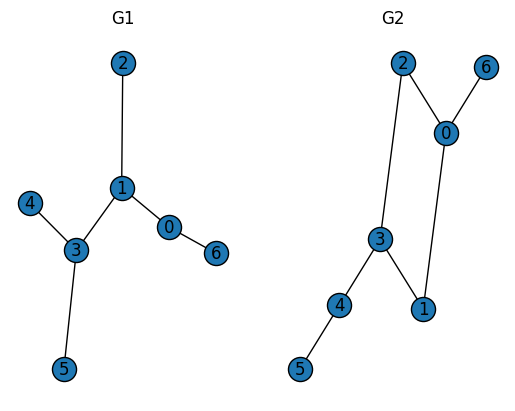

network measures G1 = [1.71, 3.71, 0.78, 0.0, 2.19, -0.45]
network measures G2 = [2.0, 4.57, 0.57, 0.0, 2.19, -0.46]
betti numbers G1: [1 0 0 0 0]
betti numbers G2: [1 1 0 0 0]


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A1 = np.array([
#    0 1 2 3 4 5 6
    [0,1,0,0,0,0,1], # 0
    [1,0,1,1,0,0,0], # 1
    [0,1,0,0,0,0,0], # 2
    [0,1,0,0,1,1,0], # 3
    [0,0,0,1,0,0,0], # 4
    [0,0,0,1,0,0,0], # 5
    [1,0,0,0,0,0,0]  # 6
    ]) 
G1 = nx.from_numpy_array(np.array(A1), create_using=nx.Graph)  

A2 = np.array([
#    0 1 2 3 4 5 6
    [0,1,1,0,0,0,1], # 0
    [1,0,0,1,0,0,0], # 1
    [1,0,0,1,0,0,0], # 2
    [0,1,1,0,1,0,0], # 3
    [0,0,0,1,0,1,0], # 4
    [0,0,0,0,1,0,0], # 5
    [1,0,0,0,0,0,0]  # 6
    ]) 
G2 = nx.from_numpy_array(np.array(A2), create_using=nx.Graph)  

plt.subplot(1,2,1)
plt.title("G1")
nx.draw_kamada_kawai(G1, with_labels=True, edgecolors='black')
plt.subplot(1,2,2)
plt.title("G2")
nx.draw_kamada_kawai(G2, with_labels=True, edgecolors='black')
plt.show()

results_G1 = network_measures(G1)
results_G2 = network_measures(G2)

print(f"network measures G1 = {[round(result, 2) for result in results_G1]}")
print(f"network measures G2 = {[round(result, 2) for result in results_G2]}")

betti_G1 = betti_numbers(G1)
betti_G2 = betti_numbers(G2)

print("betti numbers G1:", betti_G1)
print("betti numbers G2:", betti_G2)

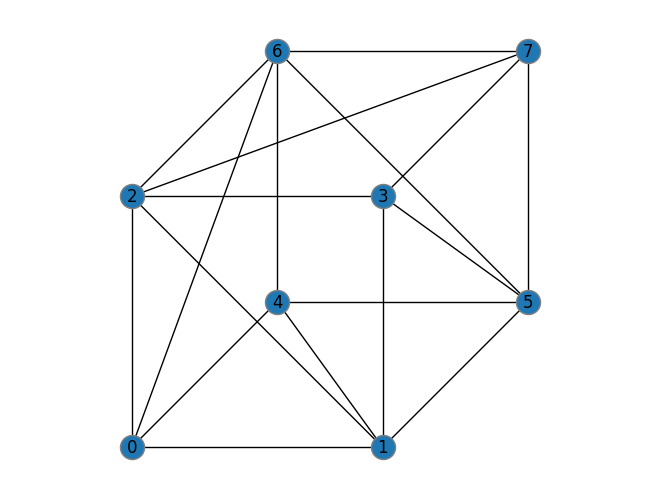

edge simplicial complex
	simplices: 26
	dimension: 1
	betti numbers: [1, 11]
	simplex resume: [8, 18]
clique simplicial complex
	simplices: 38
	dimension: 2
	betti numbers: [1, 0, 1]
	simplex resume: [8, 18, 12]


In [53]:
import networkx as nx
import matplotlib.pyplot as plt

# Monta um grafo que corresponde a a superfície de um cubo tridimensional
G = nx.Graph()

G.add_node(0)
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)
G.add_node(6)
G.add_node(7)

G.add_edge(0,1)
G.add_edge(0,2)
G.add_edge(0,4)
G.add_edge(0,6)
G.add_edge(1,4)
G.add_edge(1,5)
G.add_edge(1,3)
G.add_edge(2,6)
G.add_edge(2,7)
G.add_edge(2,3)
G.add_edge(3,5)
G.add_edge(3,7)
G.add_edge(4,5)
G.add_edge(4,6)
G.add_edge(5,7)
G.add_edge(5,6)
G.add_edge(6,7)
G.add_edge(2,1)

pos = {
    0: (0, 0),
    1: (1, 0),
    2: (0, 1),
    3: (1, 1),
    4: (0.58, 0.58),
    5: (1.58, 0.58),
    6: (0.58, 1.58),
    7: (1.58, 1.58),
}

nx.draw(G, pos, with_labels=True, edgecolors='gray')
plt.axis('equal')
plt.show()

# Converter a rede complexa em um complexo simplicial a partir da lista de arestas
edges_complex = get_simplicial_complex(G, use_cliques=False)

print("edge simplicial complex")
print("\tsimplices:", edges_complex.num_simplices())
print("\tdimension:", edges_complex.dimension())
print("\tbetti numbers:", betti_numbers_of_complex(edges_complex))
print("\tsimplex resume:", simplexes_resume(edges_complex))

# Converter a rede complexa em um complexo simplicial a partir das listas de cliques
complex = get_simplicial_complex(G)
    
print("clique simplicial complex")
print("\tsimplices:", complex.num_simplices())
print("\tdimension:", complex.dimension())
print("\tbetti numbers:", betti_numbers_of_complex(complex))
print("\tsimplex resume:", simplexes_resume(complex))

In [65]:
import networkx as nx

# Gera redes Erdos-Reni, Barabasi-Albert e Watts-Strogatz para comparar propriedades topológicas de alta ordem.
def test_generate_networks(n_nodes, av_degree, n_networks):
    # Parâmetros calculados
    p = av_degree/(n_nodes-1)
    m = int(av_degree/2)
    k = int(av_degree)

    def m_component(G):
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        return G.subgraph(Gcc[0])
    
    def draw_network(G):
        pos = nx.kamada_kawai_layout(G)
        d = dict(G.degree())
        nx.draw(G, pos, node_size=[v * 5 for v in d.values()], edgecolors='black', with_labels=False)

    for _ in range(0, n_networks):
        # Erdos-Reni
        GER = nx.erdos_renyi_graph(n_nodes, p, seed=None, directed=False)
        # Barabasi-Albert
        GBA = nx.barabasi_albert_graph(n_nodes, m, seed=None)
        # Small-world
        GWS = nx.watts_strogatz_graph(n_nodes, k, p, seed=None)
    
        plt.figure(figsize=(12, 4))

        plt.subplot(1,3,1)
        plt.title("GER")
        draw_network(GER)
        
        plt.subplot(1,3,2)
        plt.title("GBA")
        draw_network(GBA)
            
        plt.subplot(1,3,3)
        plt.title("GWS")
        draw_network(GWS)
        
        plt.show()
        
        complex_GER = get_simplicial_complex(GER)
        complex_GBA = get_simplicial_complex(GBA)
        complex_GWS = get_simplicial_complex(GWS)

        print("Betti numbers(GER) = ", betti_numbers_of_complex(complex_GER))
        print("Betti numbers(GBA) = ", betti_numbers_of_complex(complex_GBA))
        print("Betti numbers(GWS) = ", betti_numbers_of_complex(complex_GWS))
        
        print ("Simplexes resume(GER):", simplexes_resume(complex_GER))
        print ("Simplexes resume(GBA):", simplexes_resume(complex_GBA))
        print ("Simplexes resume(GWS):", simplexes_resume(complex_GWS))
            
        GER = m_component(GER)
        GBA = m_component(GBA)
        GWS = m_component(GWS)

        er_measures = network_measures(GER)
        ba_measures = network_measures(GBA)
        ws_measures = network_measures(GWS)

        print(f"Network measures(GER) = {[round(result, 2) for result in er_measures]}")
        print(f"Network measures(GBA) = {[round(result, 2) for result in ba_measures]}")
        print(f"Network measures(GWS) = {[round(result, 2) for result in ws_measures]}")

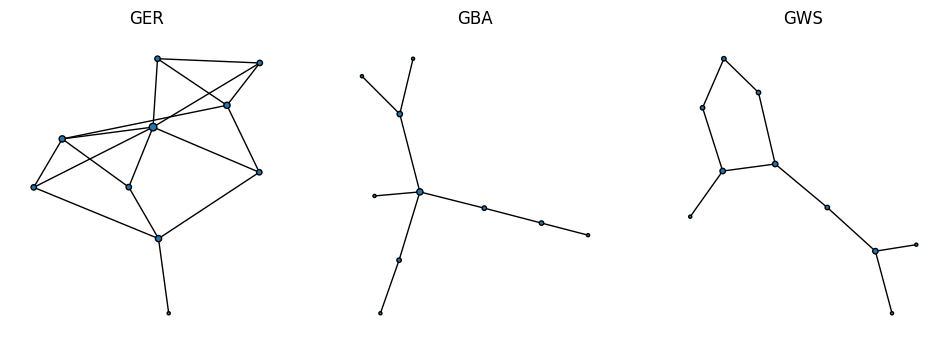

Betti numbers(GER) =  [1, 4, 0]
Betti numbers(GBA) =  [1, 0]
Betti numbers(GWS) =  [1, 1]
Simplexes resume(GER): [10, 17, 4]
Simplexes resume(GBA): [10, 9]
Simplexes resume(GWS): [10, 10]
Network measures(GER) = [3.4, 13.0, 1.44, 0.27, 1.82, -0.41]
Network measures(GBA) = [1.8, 4.2, 0.96, 0.0, 2.64, -0.27]
Network measures(GWS) = [2.0, 4.6, 0.6, 0.0, 2.69, -0.57]


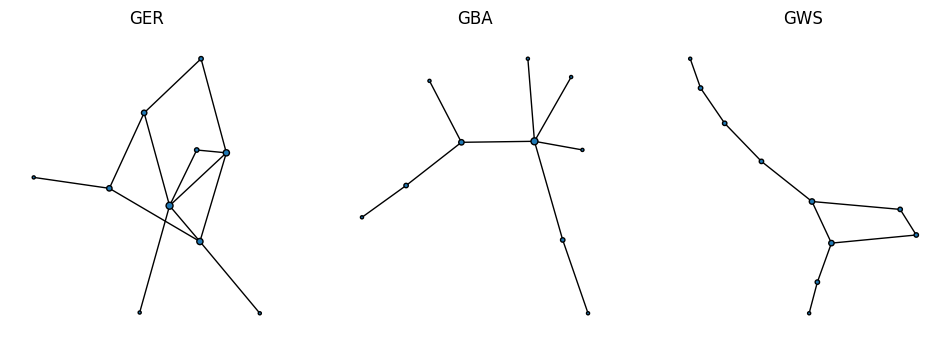

Betti numbers(GER) =  [1, 2, 0]
Betti numbers(GBA) =  [1, 0]
Betti numbers(GWS) =  [1, 1]
Simplexes resume(GER): [10, 13, 2]
Simplexes resume(GBA): [10, 9]
Simplexes resume(GWS): [10, 10]
Network measures(GER) = [2.6, 8.6, 1.84, 0.17, 2.04, -0.3]
Network measures(GBA) = [1.8, 4.8, 1.56, 0.0, 2.44, -0.48]
Network measures(GWS) = [2.0, 4.4, 0.4, 0.0, 3.0, 0.17]


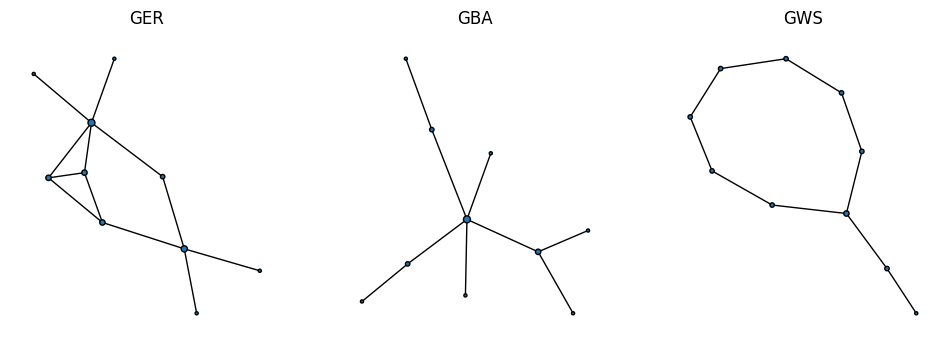

Betti numbers(GER) =  [1, 1, 0]
Betti numbers(GBA) =  [1, 0]
Betti numbers(GWS) =  [1, 1]
Simplexes resume(GER): [10, 12, 2]
Simplexes resume(GBA): [10, 9]
Simplexes resume(GWS): [10, 10]
Network measures(GER) = [2.4, 7.6, 1.84, 0.18, 2.13, -0.74]
Network measures(GBA) = [1.8, 4.8, 1.56, 0.0, 2.38, -0.39]
Network measures(GWS) = [2.0, 4.2, 0.2, 0.0, 2.69, -0.05]


In [7]:
test_generate_networks(10, 3, 3)

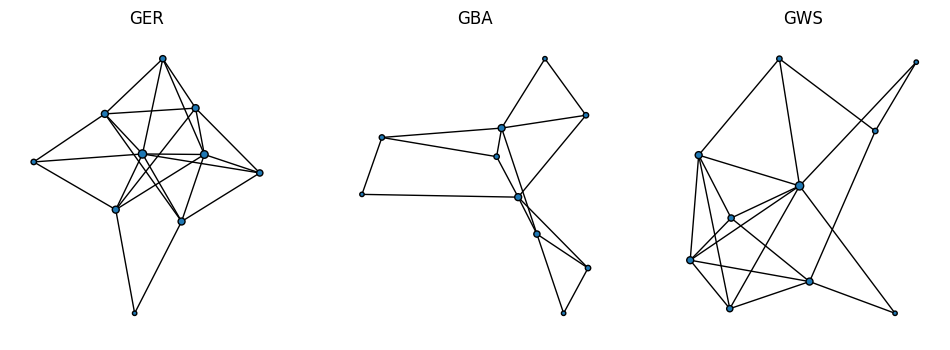

Betti numbers(GER) =  [1, 1, 0, 0]
Betti numbers(GBA) =  [1, 3, 0]
Betti numbers(GWS) =  [1, 3, 0, 0]
Simplexes resume(GER): [10, 23, 14, 1]
Simplexes resume(GBA): [10, 16, 4]
Simplexes resume(GWS): [10, 20, 10, 2]
Network measures(GER) = [4.6, 23.0, 1.84, 0.45, 1.51, -0.22]
Network measures(GBA) = [3.2, 11.4, 1.16, 0.43, 1.82, -0.3]
Network measures(GWS) = [4.0, 18.2, 2.2, 0.35, 1.56, -0.32]


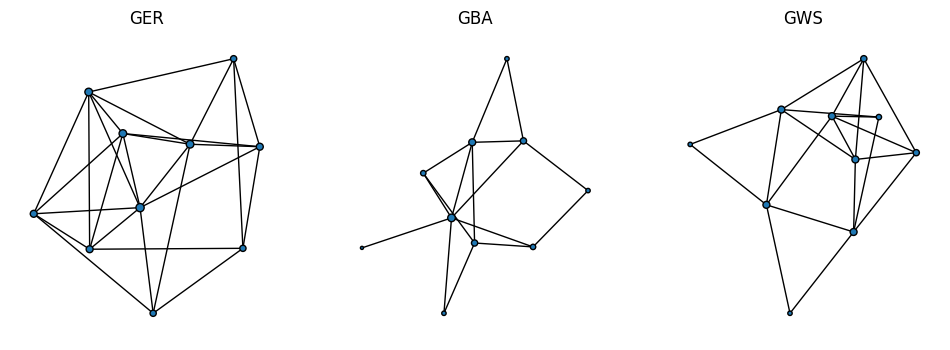

Betti numbers(GER) =  [1, 2, 0, 0, 0]
Betti numbers(GBA) =  [1, 3, 0]
Betti numbers(GWS) =  [1, 4, 0, 0]
Simplexes resume(GER): [10, 26, 21, 7, 1]
Simplexes resume(GBA): [10, 16, 4]
Simplexes resume(GWS): [10, 20, 8, 1]
Network measures(GER) = [5.2, 28.0, 0.96, 0.52, 1.42, 0.09]
Network measures(GBA) = [3.2, 12.4, 2.16, 0.27, 1.8, -0.39]
Network measures(GWS) = [4.0, 17.4, 1.4, 0.47, 1.6, -0.38]


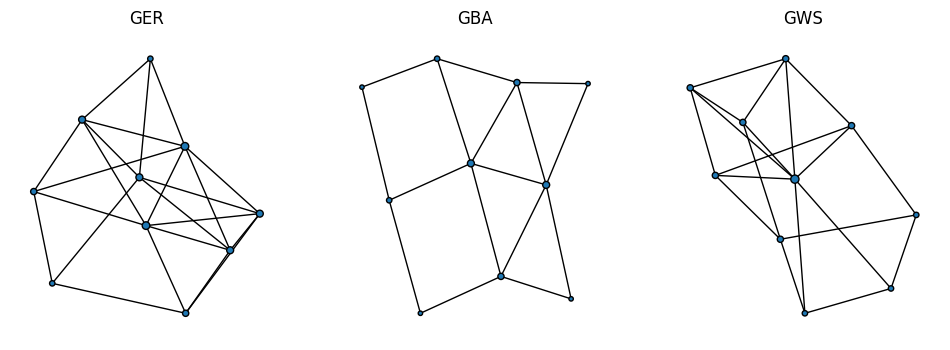

Betti numbers(GER) =  [1, 3, 0, 0]
Betti numbers(GBA) =  [1, 2, 0]
Betti numbers(GWS) =  [1, 4, 0, 0]
Simplexes resume(GER): [10, 23, 14, 3]
Simplexes resume(GBA): [10, 16, 5]
Simplexes resume(GWS): [10, 20, 8, 1]
Network measures(GER) = [4.6, 22.2, 1.04, 0.46, 1.51, -0.03]
Network measures(GBA) = [3.2, 11.6, 1.36, 0.39, 1.89, -0.06]
Network measures(GWS) = [4.0, 17.2, 1.2, 0.35, 1.58, -0.17]


In [8]:
test_generate_networks(10, 5, 3)

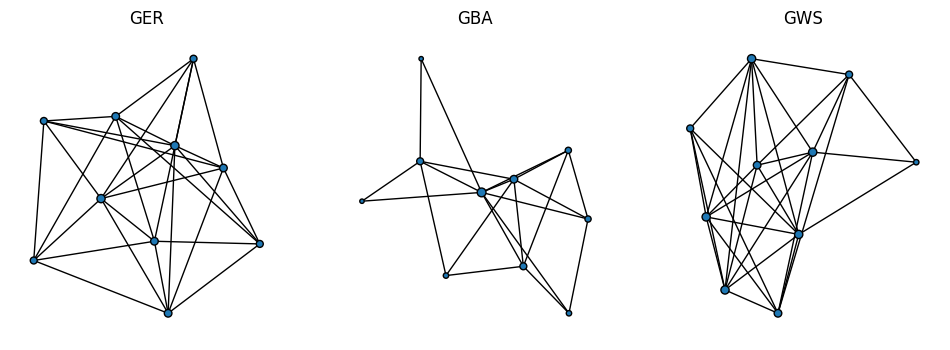

Betti numbers(GER) =  [1, 0, 2, 0]
Betti numbers(GBA) =  [1, 0, 0, 0]
Betti numbers(GWS) =  [1, 1, 0, 0, 0]
Simplexes resume(GER): [10, 29, 27, 5]
Simplexes resume(GBA): [10, 21, 14, 2]
Simplexes resume(GWS): [10, 30, 35, 19, 4]
Network measures(GER) = [5.8, 34.2, 0.56, 0.57, 1.36, -0.26]
Network measures(GBA) = [4.2, 20.8, 3.16, 0.66, 1.53, -0.38]
Network measures(GWS) = [6.0, 37.6, 1.6, 0.64, 1.33, -0.06]


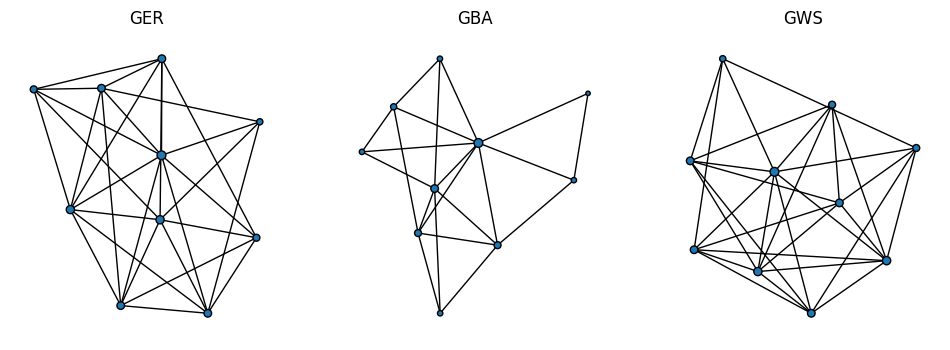

Betti numbers(GER) =  [1, 0, 1, 0, 0]
Betti numbers(GBA) =  [1, 0, 0, 0]
Betti numbers(GWS) =  [1, 0, 0, 0, 0]
Simplexes resume(GER): [10, 30, 32, 11, 1]
Simplexes resume(GBA): [10, 21, 14, 2]
Simplexes resume(GWS): [10, 30, 32, 12, 1]
Network measures(GER) = [6.0, 37.2, 1.2, 0.63, 1.33, -0.32]
Network measures(GBA) = [4.2, 20.6, 2.96, 0.65, 1.56, -0.31]
Network measures(GWS) = [6.0, 37.2, 1.2, 0.61, 1.33, -0.15]


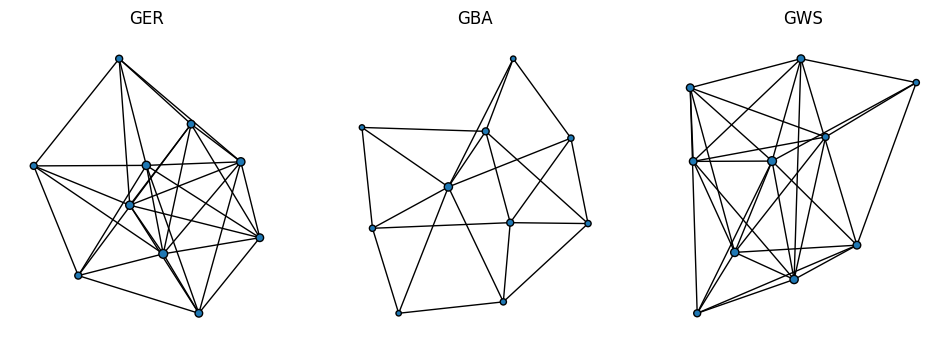

Betti numbers(GER) =  [1, 0, 1, 0, 0]
Betti numbers(GBA) =  [1, 3, 0]
Betti numbers(GWS) =  [1, 1, 0, 0, 0]
Simplexes resume(GER): [10, 31, 36, 16, 3]
Simplexes resume(GBA): [10, 21, 9]
Simplexes resume(GWS): [10, 30, 33, 14, 1]
Network measures(GER) = [6.2, 39.4, 0.96, 0.65, 1.31, -0.13]
Network measures(GBA) = [4.2, 19.0, 1.36, 0.44, 1.53, -0.36]
Network measures(GWS) = [6.0, 37.2, 1.2, 0.63, 1.33, -0.12]


In [9]:
test_generate_networks(10, 6, 3)

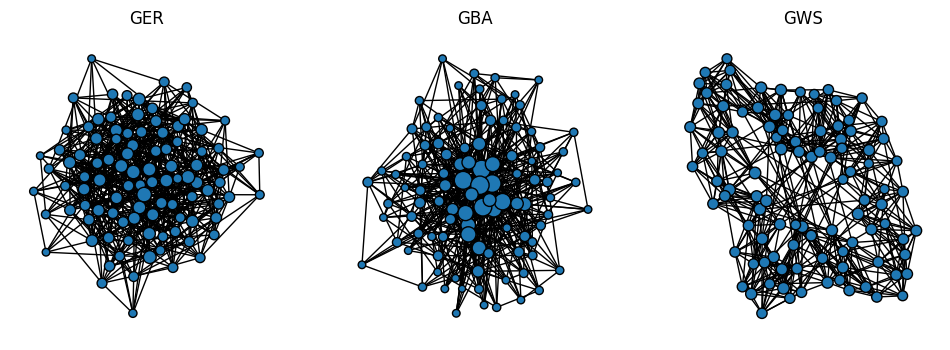

Betti numbers(GER) =  [1, 249, 0, 0]
Betti numbers(GBA) =  [1, 108, 6, 0, 0, 0]
Betti numbers(GWS) =  [1, 53, 3, 0, 0, 0, 0]
Simplexes resume(GER): [100, 599, 258, 7]
Simplexes resume(GBA): [100, 564, 491, 154, 29, 3]
Simplexes resume(GWS): [100, 600, 1039, 925, 418, 85, 4]
Network measures(GER) = [11.98, 152.48, 8.96, 0.11, 2.08, 0.03]
Network measures(GBA) = [11.28, 177.14, 49.9, 0.21, 2.11, -0.1]
Network measures(GWS) = [12.0, 145.5, 1.5, 0.47, 2.42, 0.01]


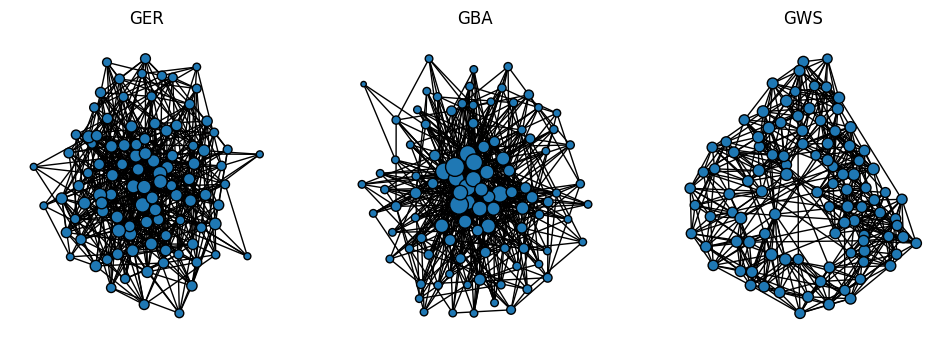

Betti numbers(GER) =  [1, 227, 0, 0]
Betti numbers(GBA) =  [1, 113, 5, 0, 0]
Betti numbers(GWS) =  [1, 66, 6, 0, 0, 0, 0]
Simplexes resume(GER): [100, 587, 271, 10]
Simplexes resume(GBA): [100, 564, 488, 149, 18]
Simplexes resume(GWS): [100, 600, 994, 845, 360, 74, 6]
Network measures(GER) = [11.74, 149.26, 11.43, 0.12, 2.11, -0.03]
Network measures(GBA) = [11.28, 180.5, 53.26, 0.21, 2.1, -0.16]
Network measures(GWS) = [12.0, 145.4, 1.4, 0.45, 2.4, 0.02]


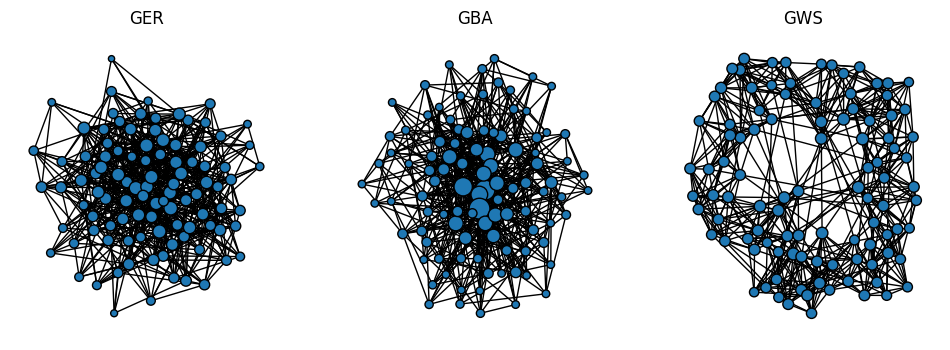

Betti numbers(GER) =  [1, 250, 0, 0]
Betti numbers(GBA) =  [1, 94, 11, 0, 0, 0]
Betti numbers(GWS) =  [1, 52, 2, 0, 0, 0, 0]
Simplexes resume(GER): [100, 606, 267, 10]
Simplexes resume(GBA): [100, 564, 534, 182, 31, 1]
Simplexes resume(GWS): [100, 600, 1056, 933, 397, 74, 5]
Network measures(GER) = [12.12, 156.68, 9.79, 0.11, 2.07, -0.03]
Network measures(GBA) = [11.28, 181.0, 53.76, 0.22, 2.1, -0.11]
Network measures(GWS) = [12.0, 145.56, 1.56, 0.48, 2.44, 0.01]


In [10]:
test_generate_networks(100, 12, 3)

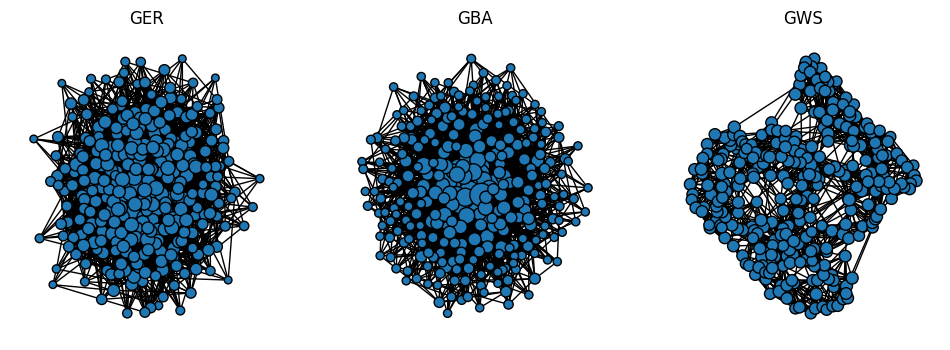

Betti numbers(GER) =  [1, 1341, 0, 0]
Betti numbers(GBA) =  [1, 669, 30, 0, 0]
Betti numbers(GWS) =  [1, 98, 0, 2, 0, 0, 0, 0]
Simplexes resume(GER): [297, 2104, 468, 1]
Simplexes resume(GBA): [297, 2030, 1440, 397, 52]
Simplexes resume(GWS): [297, 2079, 5353, 7670, 6335, 3031, 781, 85]
Network measures(GER) = [14.17, 214.52, 13.78, 0.05, 2.44, -0.03]
Network measures(GBA) = [13.67, 306.36, 119.49, 0.12, 2.39, -0.08]
Network measures(GWS) = [14.0, 196.76, 0.76, 0.59, 3.32, 0.01]


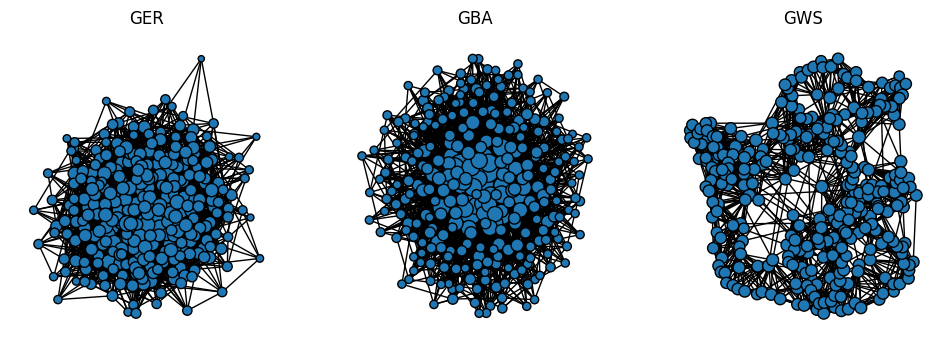

Betti numbers(GER) =  [1, 1298, 0, 0]
Betti numbers(GBA) =  [1, 704, 43, 0, 0, 0]
Betti numbers(GWS) =  [1, 81, 0, 0, 0, 0, 0, 0]
Simplexes resume(GER): [297, 2031, 439, 2]
Simplexes resume(GBA): [297, 2030, 1376, 368, 75, 10]
Simplexes resume(GWS): [297, 2079, 5510, 8088, 6826, 3304, 842, 84]
Network measures(GER) = [13.68, 201.13, 14.08, 0.05, 2.47, 0.02]
Network measures(GBA) = [13.67, 294.76, 107.89, 0.11, 2.41, -0.04]
Network measures(GWS) = [14.0, 196.54, 0.54, 0.61, 3.44, 0.01]


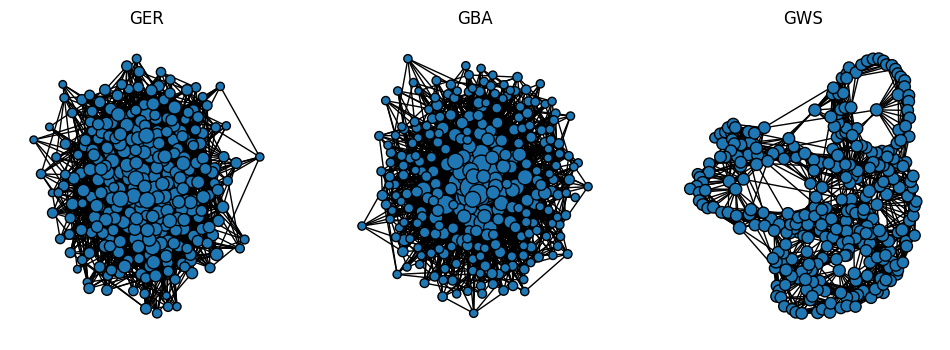

Betti numbers(GER) =  [1, 1324, 0, 0]
Betti numbers(GBA) =  [1, 672, 19, 0, 0, 0]
Betti numbers(GWS) =  [1, 85, 0, 0, 0, 0, 0, 0]
Simplexes resume(GER): [297, 2066, 450, 4]
Simplexes resume(GBA): [297, 2030, 1484, 504, 111, 10]
Simplexes resume(GWS): [297, 2079, 5495, 8062, 6809, 3321, 875, 98]
Network measures(GER) = [13.91, 208.27, 14.71, 0.05, 2.45, -0.01]
Network measures(GBA) = [13.67, 312.28, 125.41, 0.12, 2.38, -0.08]
Network measures(GWS) = [14.0, 196.55, 0.55, 0.61, 3.43, -0.03]


In [11]:
test_generate_networks(297, 14, 3)

network_measures= (14.464646464646465, 376.7811447811448, 167.5551474339353, 0.29236329783219006, 2.455318955318955, -0.16319921031570375)
simplices: 8779
dimension: 7
betti_numbers= [1, 139, 121, 4, 0, 0, 0, 0]
simplex resume= [297, 2148, 3241, 2010, 801, 240, 40, 2]


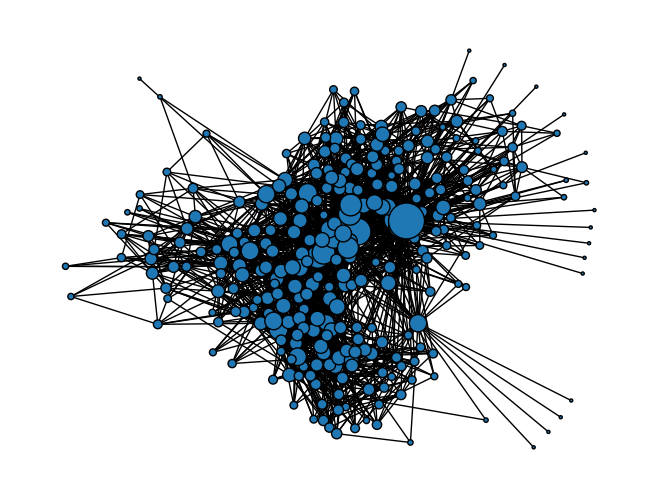

In [12]:
filename = "data/out.dimacs10-celegansneural"

G = OpenNetwork(filename, digraph=False)

pos = nx.spring_layout(G, seed=42)
d = dict(G.degree())
nx.draw(G, pos, node_size=[v * 5 for v in d.values()], edgecolors='black', with_labels=False)

complex = get_simplicial_complex(G)

print("network_measures=", network_measures(G))
print("simplices:", complex.num_simplices())
print("dimension:", complex.dimension())
print("betti_numbers=", betti_numbers_of_complex(complex))
print("simplex resume=", simplexes_resume(complex))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import umap

def classifier(y, X, X_test, cl=['ER','WS','BA'], colors=['red', 'blue', 'green']):
    y = np.array(y)

    # Padroniza os recursos removendo a média e dimensionando para a variância da unidade.
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_test = np.array(X_test)
    X_test = X_test.reshape(1,len(X_test)) 
    X_test = scaler.transform(X_test)

    # Reduz para 2 dimensões com PCA Principal Component Analysis
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))

    # Reduz para 2 dimensões com Linear Discriminant Analysis
    lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

    # Reduz para 2 dimensões com Uniform Manifold Approximation and Projection
    uma = umap.UMAP()

    dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("UMAP", uma)]

    n_neighbors=10
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = 'euclidean')
 
    plt.figure(figsize=(14, 4))
    # Plot each method's projection
    for i, (name, model) in enumerate(dim_reduction_methods):
        plt.subplot(1,3,i+1)

        # Fit the method's model
        model.fit(X, y)

        # Embed the data set in 2 dimensions using the fitted model
        X_embedded = model.transform(X)
        
        # Embed the test case in 2 dimensions using the fitted model
        X_test_embedded = model.transform(X_test.reshape(1, -1))
    
        # Make predictions using KNN
        knn.fit(X_embedded, y)
                
        # Find the k nearest neighbors to the center point
        _, indices = knn.kneighbors(X_test_embedded, n_neighbors=k)
        neighbors = X_embedded[indices][0]
        
        # Calculate the radius of the circle
        radius = np.max(np.linalg.norm(neighbors - X_test_embedded, axis=1))
        
        # Draw a circle around the center point with the calculated radius
        circle = plt.Circle([X_test_embedded[:,0], X_test_embedded[:,1]], radius, color='black', fill=False, linestyle='dashed')
        plt.gca().add_artist(circle)
        
        y_pred = knn.predict(X_test_embedded)
            
        print('Class:', cl[int(np.mean(y_pred))])
        
        for j in range(len(cl)):
            plt.scatter(
                X_embedded[y == j, 0],
                X_embedded[y == j, 1],
                c=colors[j],
                s=30,
                label=cl[j],
            )
        plt.scatter(
            X_test_embedded[:, 0],
            X_test_embedded[:, 1],
            c='black',
            s=100,
            marker="X",
            label="Test Case",
        )
        plt.legend()
        plt.title(name)
        plt.axis('equal')
        
    plt.show()

number of nodes=297 average degree=14.464646464646465
Class: BA
Class: BA
Class: BA


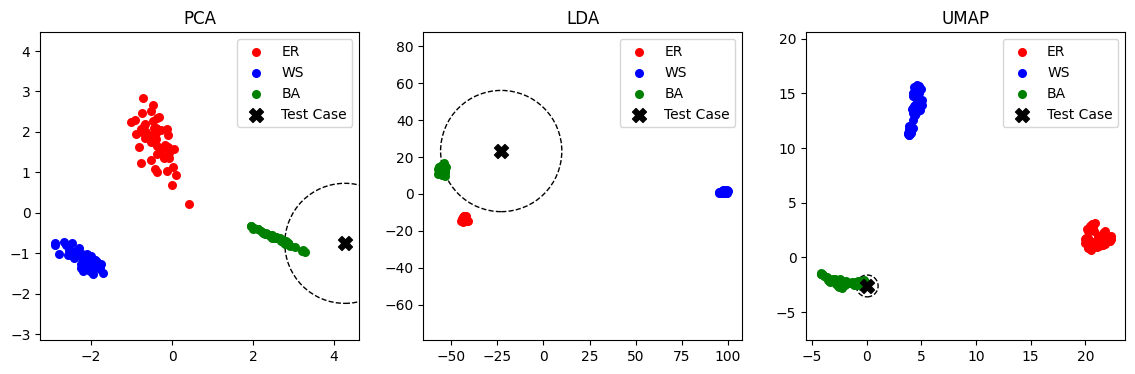

Class: WS
Class: WS
Class: BA


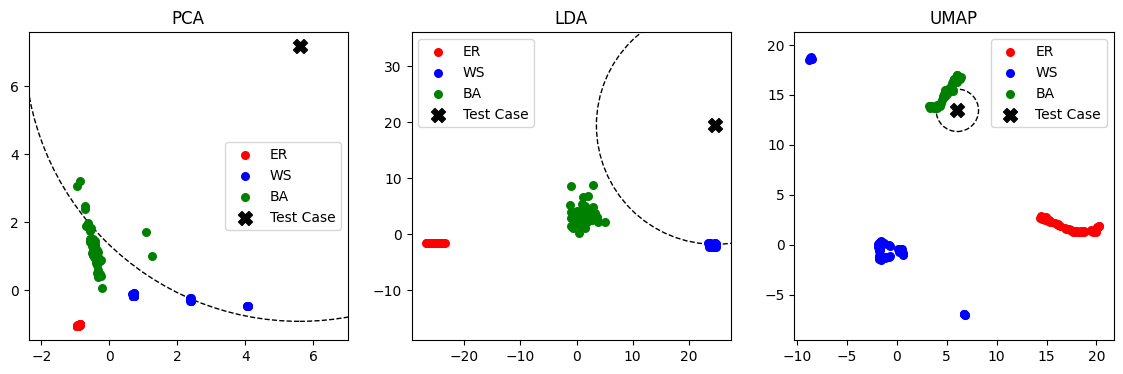

Class: ER
Class: BA
Class: ER


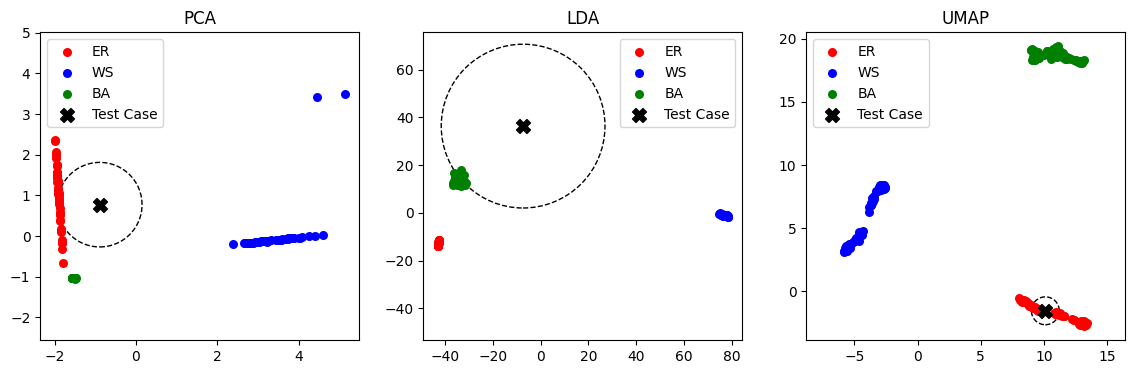

In [18]:
import networkx as nx

# Parâmetros de simulação
n_nets = 50  # Quantidade de redes
n_nodes = len(G)  # Quantidade de vértices
av_degree = momment_of_degree_distribution(G, 1) # Grau médio

print(f"number of nodes={n_nodes} average degree={av_degree}")

# Vetores para impressão de resultados
X_measures = []
X_betti_num = []
X_simplex_dim = []
y = []

#ER networks
p = av_degree/(n_nodes-1)
for i in range(0,n_nets):
    GER = nx.gnp_random_graph(n_nodes, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    
    k1,k2,variance,av_cl,l,r = network_measures(GER)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    
    complex = get_simplicial_complex(GER)
    x = betti_numbers_of_complex(complex, vector_len=5)
    X_betti_num.append(x)
    
    x = simplexes_resume(complex, vector_len=11)
    X_simplex_dim.append(x)
    
    y.append(0)

#WS networks
k = int(av_degree)
p = 0.05 #probability of rewiring
for i in range(0,n_nets):
    GWS = nx.watts_strogatz_graph(n_nodes, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        
    k1,k2,variance,av_cl,l,r = network_measures(GWS)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    
    complex = get_simplicial_complex(GWS)
    x = betti_numbers_of_complex(complex, vector_len=5)
    X_betti_num.append(x)
    
    x = simplexes_resume(complex, vector_len=11)
    X_simplex_dim.append(x)
    
    y.append(1)

# BA networks
m = int(av_degree/2)
for i in range(0,n_nets):
    GBA = nx.barabasi_albert_graph(n_nodes, m)    
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    
    k1,k2,variance,av_cl,l,r = network_measures(GBA)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    
    complex = get_simplicial_complex(GBA)
    x = betti_numbers_of_complex(complex, vector_len=5)
    X_betti_num.append(x)
    
    x = simplexes_resume(complex, vector_len=11)
    X_simplex_dim.append(x)
    
    y.append(2)
    

k1,k2,variance,av_cl,l,r = network_measures(G)
X_test = [k1, k2, variance, av_cl, l, r]
classifier(y, X_measures, X_test)

complex = get_simplicial_complex(G)

X_test = betti_numbers_of_complex(complex, vector_len=5)
classifier(y, X_betti_num, X_test)

X_test = simplexes_resume(complex, vector_len=11)
classifier(y, X_simplex_dim, X_test)


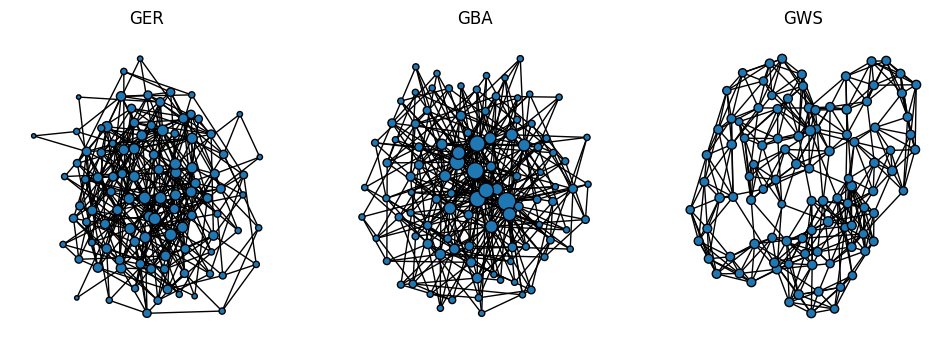

Betti numbers(GER) =  [1, 211, 0, 0]
Betti numbers(GBA) =  [1, 123, 1, 0]
Betti numbers(GWS) =  [1, 27, 0, 0, 0]
Simplexes resume(GER): [100, 375, 66, 1]
Simplexes resume(GBA): [100, 384, 186, 23]
Simplexes resume(GWS): [100, 400, 496, 276, 54]
Network measures(GER) = [7.5, 64.36, 8.11, 0.08, 2.49, 0.03]
Network measures(GBA) = [7.68, 91.46, 32.48, 0.2, 2.36, -0.16]
Network measures(GWS) = [8.0, 64.6, 0.6, 0.53, 3.24, -0.0]


In [78]:
test_generate_networks(100, 8, 1)

In [120]:
import networkx as nx

# Gera redes Erdos-Reni, Barabasi-Albert e Watts-Strogatz para comparar propriedades topológicas de alta ordem.
def test_generate_networks_plot_degree_betti_num(n_nodes, av_degree_start, av_degree_stop, n_networks):
    X = []
    Y_GER = []
    Y_GBA = []
    Y_GWS = []
    for av_degree in range(av_degree_start, av_degree_stop):    
        X.append(av_degree)
        betti_GER = [0,0,0,0,0,0,0]
        betti_GBA = [0,0,0,0,0,0,0]
        betti_GWS = [0,0,0,0,0,0,0]
        for _ in range(0, n_networks):
            p = av_degree/(n_nodes-1)
            m = int(av_degree/2)
            k = int(av_degree)
            # Erdos-Reni
            GER = nx.erdos_renyi_graph(n_nodes, p, seed=None, directed=False)
            # Barabasi-Albert
            GBA = nx.barabasi_albert_graph(n_nodes, m, seed=None)
            # Small-world
            GWS = nx.watts_strogatz_graph(n_nodes, k, p, seed=None)
            
            betti_GER = np.array(betti_GER) + np.array(betti_numbers(GER))
            betti_GBA = np.array(betti_GBA) + np.array(betti_numbers(GBA))
            betti_GWS = np.array(betti_GWS) + np.array(betti_numbers(GWS))
        
        betti_GER = betti_GER / n_networks
        betti_GBA = betti_GBA / n_networks
        betti_GWS = betti_GWS / n_networks
        
        Y_GER.append(betti_GER)
        Y_GBA.append(betti_GBA)
        Y_GWS.append(betti_GWS)
            
    
    Y_GER = list(map(list, zip(*Y_GER)))
    Y_GBA = list(map(list, zip(*Y_GBA)))
    Y_GWS = list(map(list, zip(*Y_GWS)))
    
    # Loop for para plotar os gráficos
    for i in range(7):
        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.title('ER')
        plt.plot(X, Y_GER[i], label=f'Dim {i}')
        plt.legend()
    
        plt.subplot(1,3,2)
        plt.title('BA')
        plt.plot(X, Y_GBA[i], label=f'Dim {i}')
        plt.legend()
    
        plt.subplot(1,3,3)
        plt.title('WS')
        plt.plot(X, Y_GWS[i], label=f'Dim {i}')
        plt.legend()
        
        plt.show()

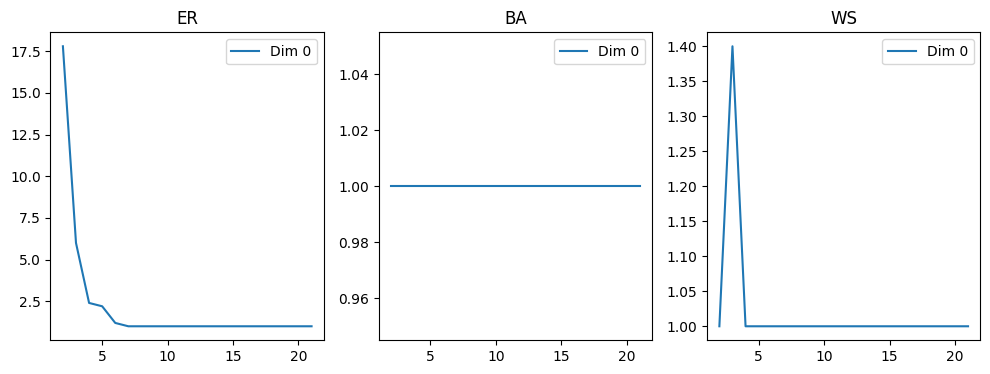

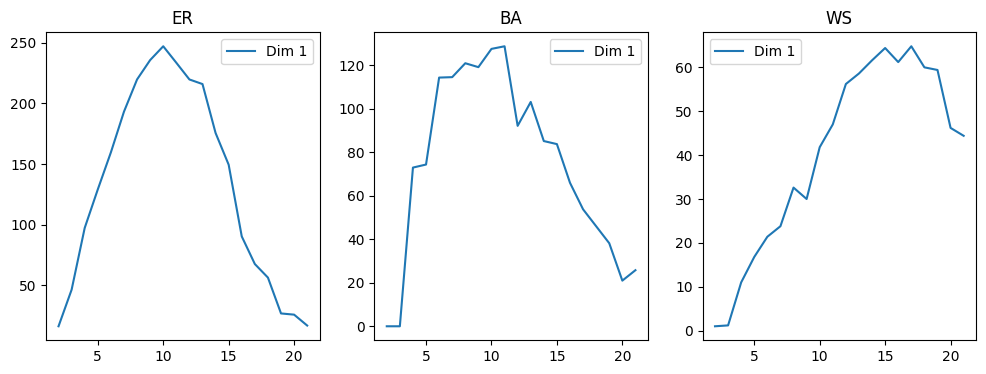

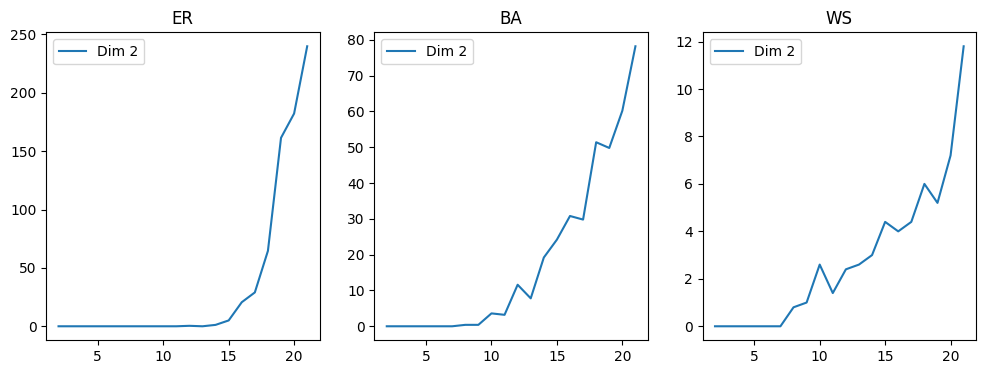

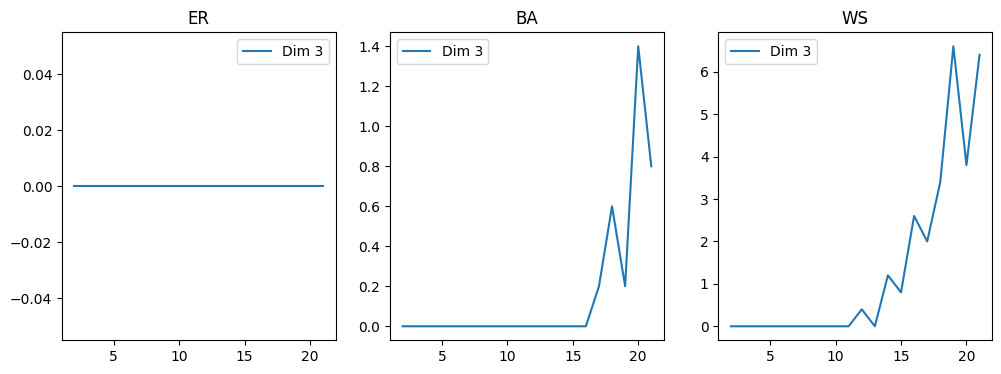

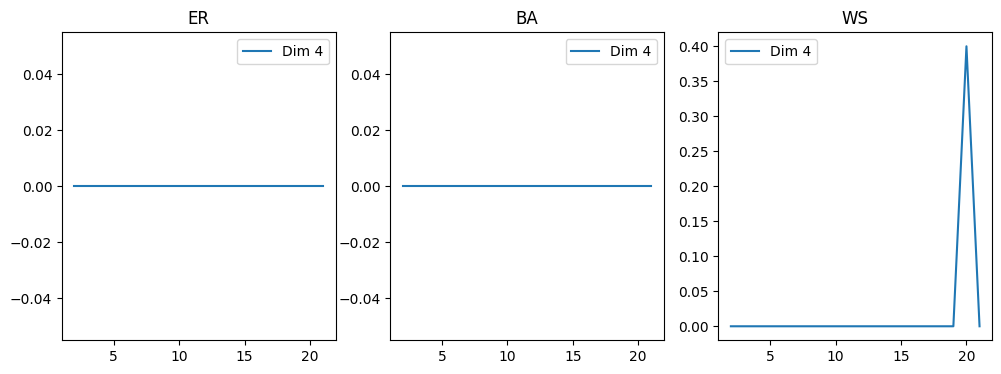

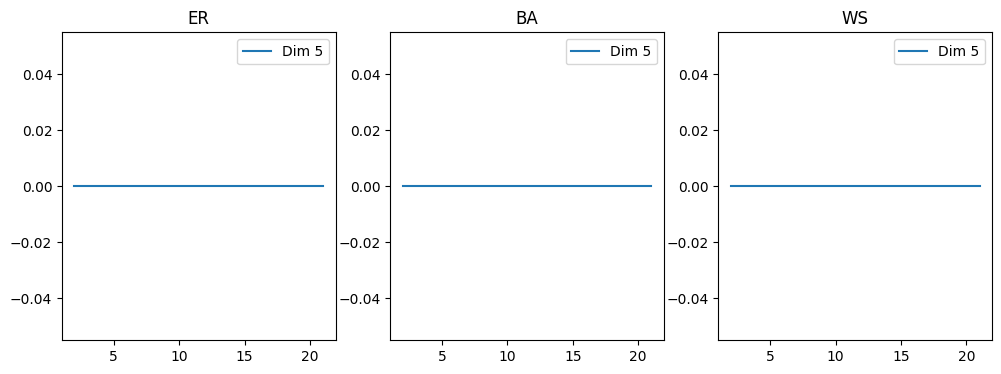

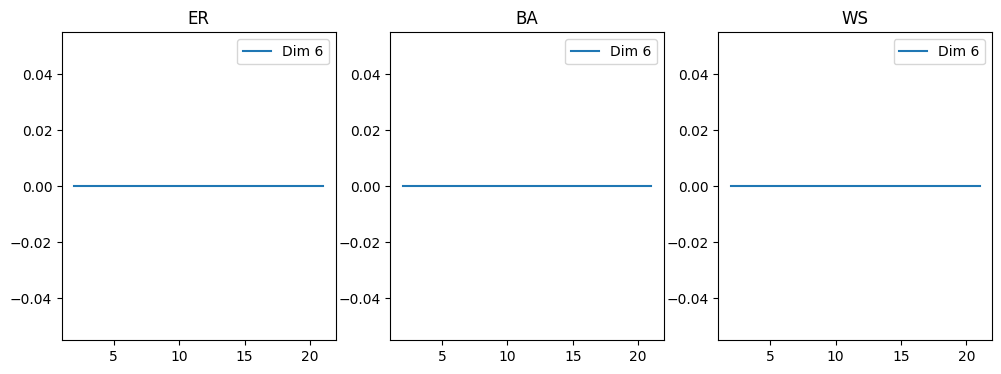

In [121]:
test_generate_networks_plot_degree_betti_num(100, 2, 22, 5)

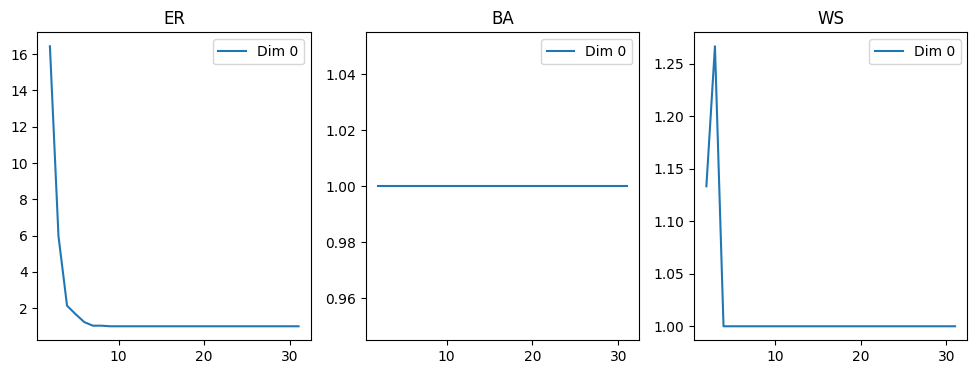

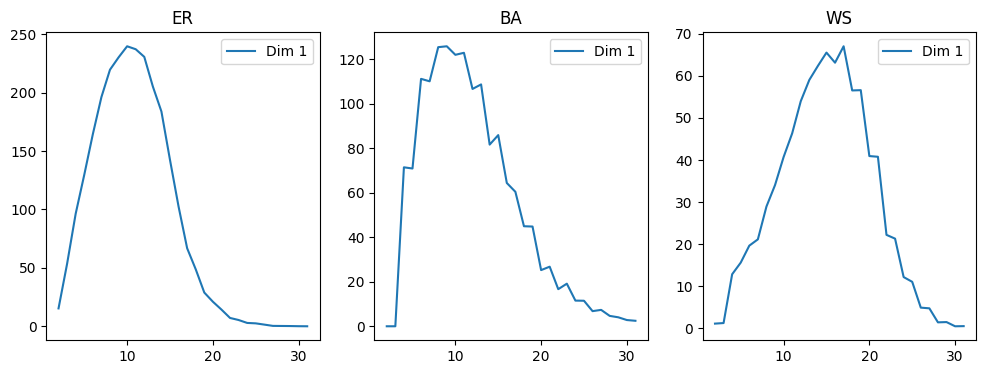

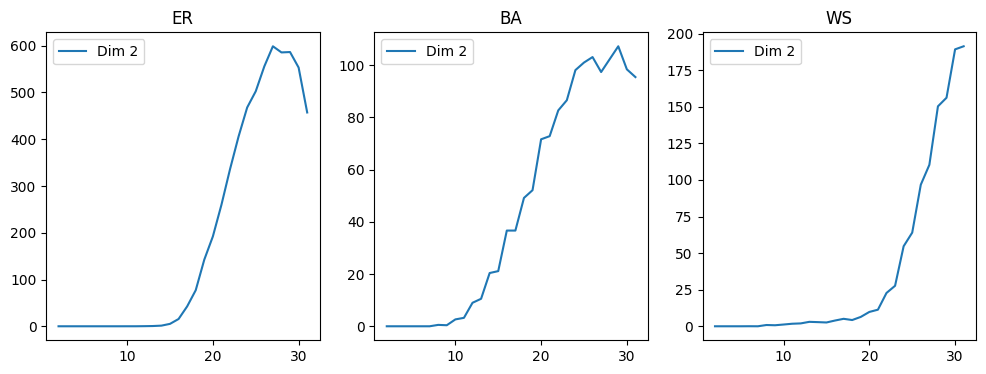

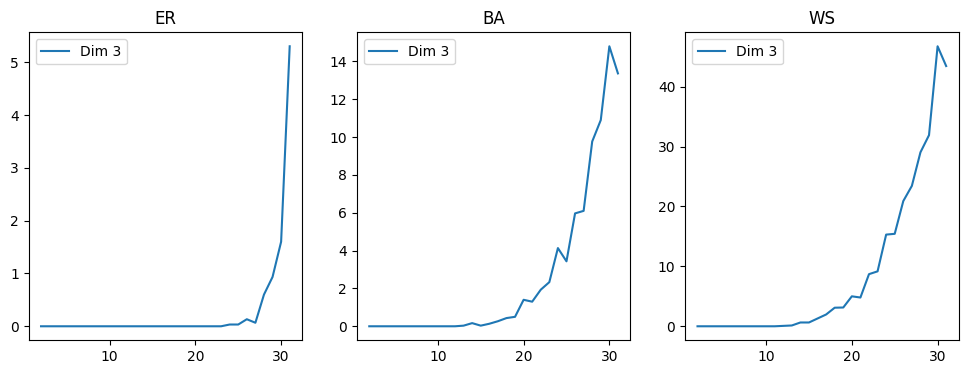

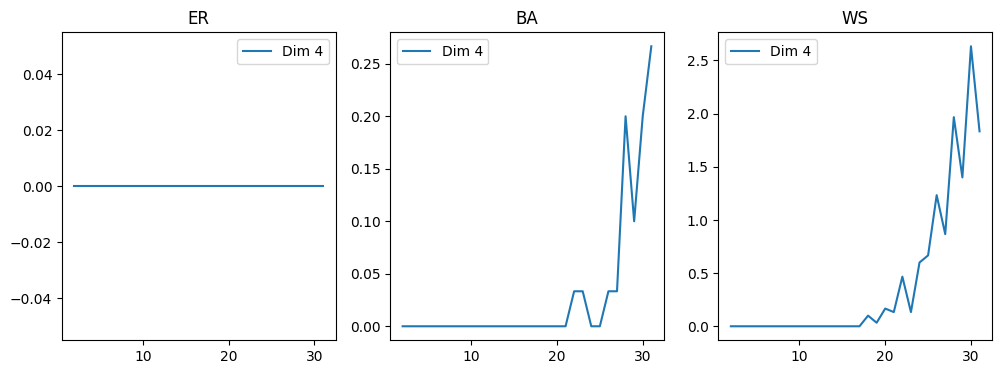

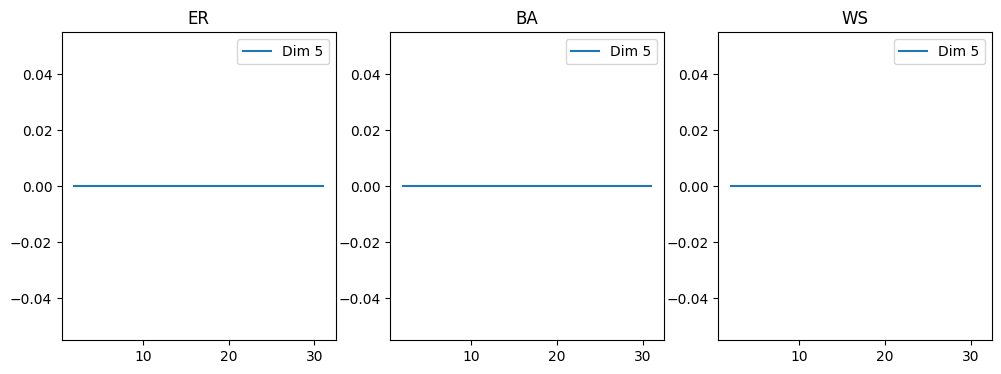

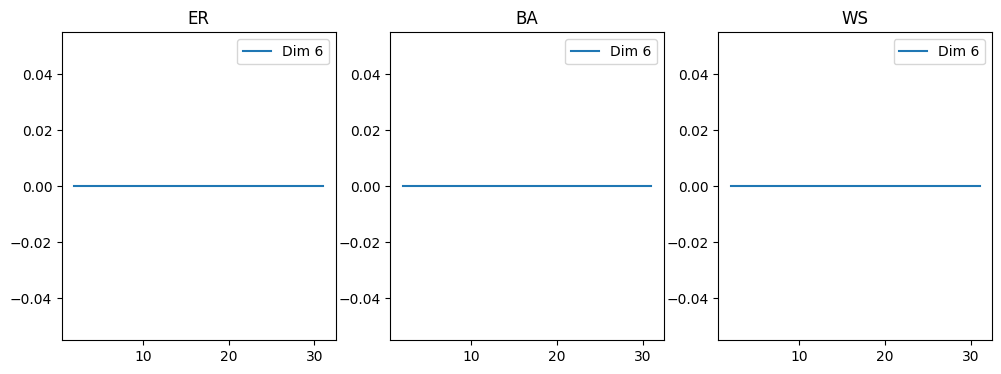

In [122]:
test_generate_networks_plot_degree_betti_num(100, 2, 32, 30)

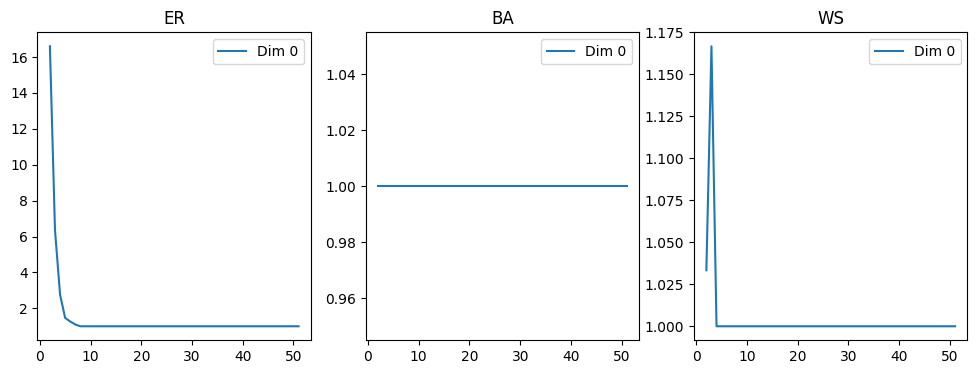

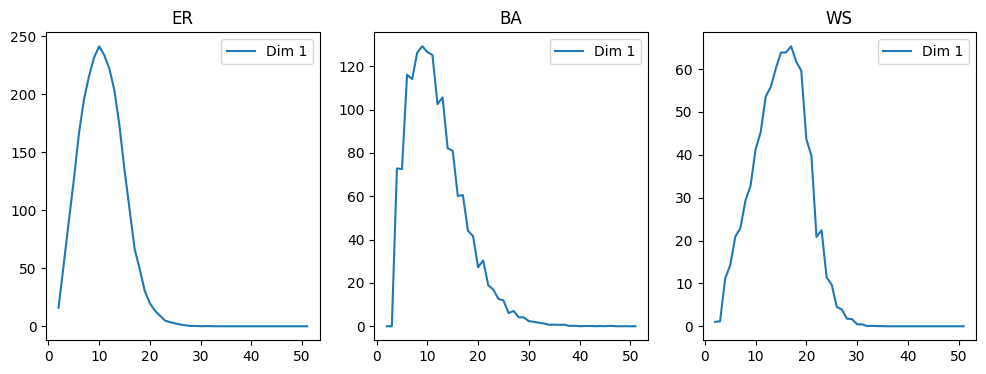

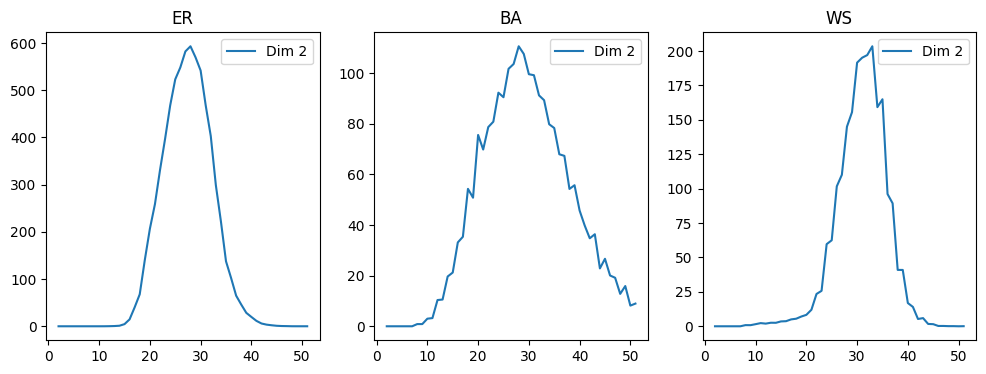

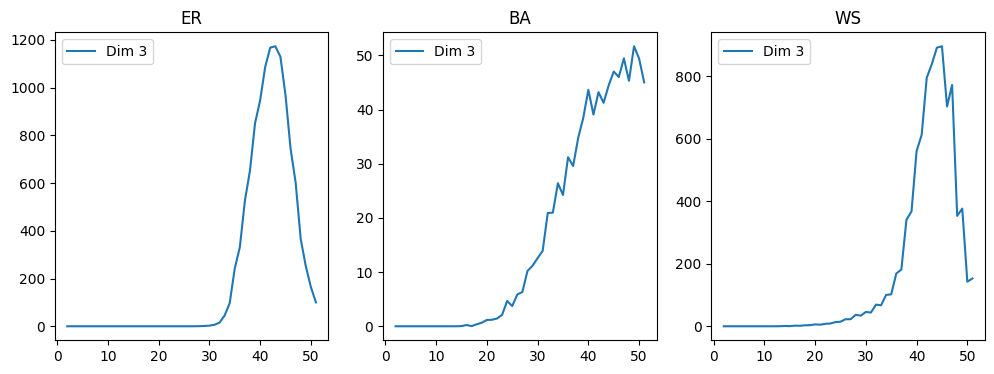

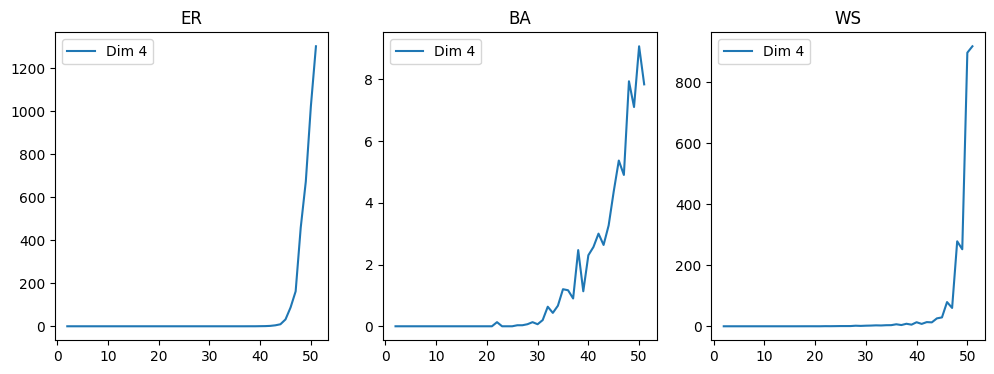

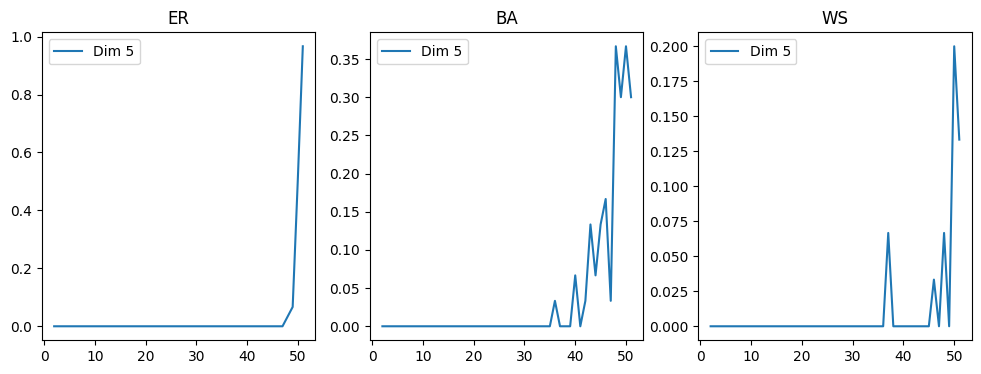

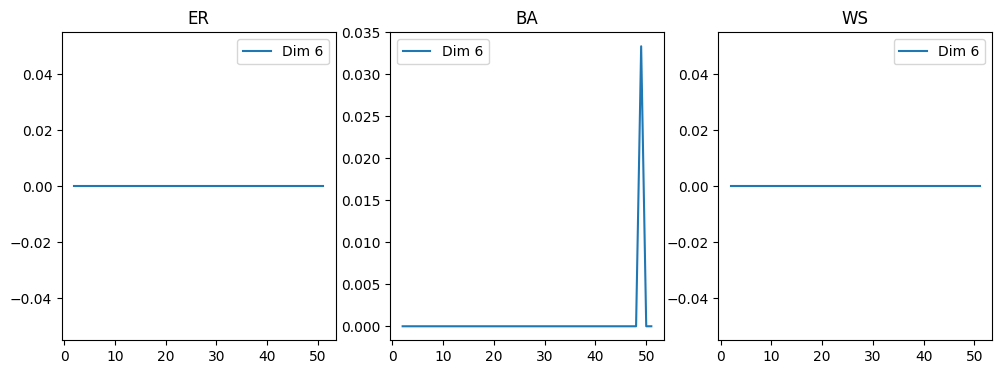

In [123]:
test_generate_networks_plot_degree_betti_num(100, 2, 52, 30)